Build training, validation and testing datasets

In [57]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time

Retrieve all file names

In [66]:
data_path = '../genres'
genre_path_dict = dict()
label_dict = dict()

for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
            label_dict[genre] = idx
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'au' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)

total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file

1000

Create MFCC and log-power Mel spectrogram

In [20]:
# global varibles:
sr = 16000
sample_time = 30  # 30 s
wave_length = sample_time * sr
n_ftt = 512
hop = n_ftt // 4

In [48]:
def feature_extractor(file_path):
    """
    Take au file path and output log mel spectrogram and MFCC
    """
    signal, _ = librosa.load(file_path, sr=sr)
    signal = signal[: wave_length]
    signal = signal if not len(signal) < wave_length else np.concatenate([signal, np.zeros(wave_length-len(signal))])
    
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    log_mel = librosa.power_to_db(mel)
    # shape: n_mels, t -> 128 * 938
    
    mfcc = librosa.feature.mfcc(S=log_mel)
    # shape: n_mfcc, t-> 20 * 938
    
    return log_mel, mfcc

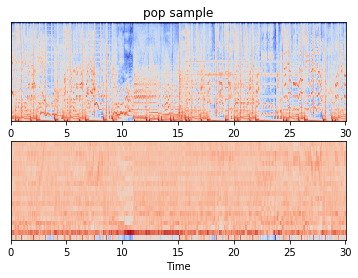

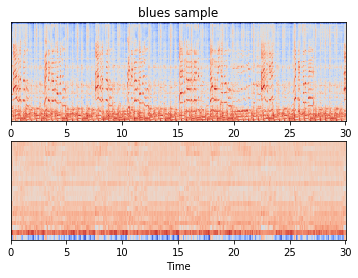

In [55]:
# test:
signal, mfcc = feature_extractor(genre_path_dict['pop'][0])
plt.subplot(2, 1, 1)
plt.title('pop sample')
display.specshow(signal, sr=sr, x_axis='time')
plt.subplot(2, 1, 2)
display.specshow(mfcc, sr=sr, x_axis='time')
plt.show()

signal, mfcc = feature_extractor(genre_path_dict['blues'][0])
plt.subplot(2, 1, 1)
plt.title('blues sample')
display.specshow(signal, sr=sr, x_axis='time')
plt.subplot(2, 1, 2)
display.specshow(mfcc, sr=sr, x_axis='time')
plt.show()

Build datasets

In [98]:
def build_tag(genre):
    target = np.zeros(len(label_dict), dtype=int)
    pos = label_dict.get(genre)
    target[pos] = 1
    return target

build_tag('pop').shape

(10,)

In [99]:
mel_shape, mfcc_shape = signal.shape, mfcc.shape
mel_shape, mfcc_shape 

((128, 938), (20, 938))

In [101]:
data_set_path = '../datasets/all.hdf5'
dataset = h5py.File(data_set_path, 'a')

In [102]:
dataset.create_dataset('mel', shape=(total_file, mel_shape[0], mel_shape[1]), dtype=np.float32)
dataset.create_dataset('mfcc', shape=(total_file, mfcc_shape[0], mfcc_shape[1]), dtype=np.float32)
dataset.create_dataset('tag', shape=(total_file, 10 ), dtype=int)        

<HDF5 dataset "tag": shape (1000, 10), type "<i8">

In [108]:
count = 0
for key in label_dict:
    print('deal with {0} with current progress {1}%'.format(key, count/total_file*100))
    for file in genre_path_dict.get(key):
        dataset['mel'][count], dataset['mfcc'][count] = feature_extractor(file)
        dataset['tag'][count] = build_tag(key)
        count += 1

deal with pop with current progress 0.0%
deal with metal with current progress 10.0%
deal with disco with current progress 20.0%
deal with blues with current progress 30.0%
deal with reggae with current progress 40.0%
deal with classical with current progress 50.0%
deal with rock with current progress 60.0%
deal with hiphop with current progress 70.0%
deal with country with current progress 80.0%
deal with jazz with current progress 90.0%
